### TabNet - simple binary classification

reference: 

https://github.com/dreamquark-ai/tabnet/blob/develop/census_example.ipynb

#### steps:
1. download market data using yfinance: download S&P 500 ('^GSPC')
1. calculate return 20-day max return (i.e. target in supervised learning problem):
   - for each date (T):
      - calculate the max price change in next 20 trading dates: price_change = (max{close price in T+1 to T+20} - {close price on T})/({close price on T})
1. convert the 20-day max return into binary target
1. engineer a few features
    - lag21: previous 21 day target
    - lag31: previous 31 day target
    - lag41: previous 41 day target
    - day price change: the difference between open and closing prices
        - (Close - Open)/Open
    - day max price change: the difference between high and low prices
        - (High-Low)/Open
    - one day close price change: day T close price versus day T-1 close price.
        - 100*({Close on T} - {Close on T-1})/{Close on T-1}
    - 10 day close price change: day T close price versus day T-10 close price.
        - 100*({Close on T} - {Close on T-10})/{Close on T-10}
    - 20 day close price change: day T close price versus day T-20 close price.
        - 100*({Close on T} - {Close on T-20})/{Close on T-20}
    - one day/10day/20day volume change

1. feed data into tabnet classifier
1. visualize the loss/performance in each epoch

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
import yfinance as yf #to download stock price data

In [4]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import os
from pathlib import Path
import shutil

In [5]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [7]:
#initiate random seed
import random
def init_seed(random_seed):
    
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
init_seed(5678)

#### download S&P 500 price data

In [8]:
ticker = '^GSPC'
cur_data = yf.Ticker(ticker)
hist = cur_data.history(period="max")
print(ticker, hist.shape, hist.index.min())

^GSPC (19721, 7) 1927-12-30 00:00:00


In [9]:
df=hist[hist.index>='2000-01-01'].copy(deep=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0,0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0,0


#### calcualte max return in next 20 trading days

In [10]:
#for each stock_id, get the max close in next 20 trading days
price_col = 'Close'
roll_len=20
new_col = 'next_20day_max'
target_list = []

df.sort_index(ascending=True, inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0,0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0,0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0,0


In [11]:
df_next20dmax=df[[price_col]].shift(1).rolling(roll_len).max()
df_next20dmax.columns=[new_col]
df = df.merge(df_next20dmax, right_index=True, left_index=True, how='inner')

df.dropna(how='any', inplace=True)
df['target']= 100*(df[new_col]-df[price_col])/df[price_col]  

In [12]:
df['target'].describe()

count    5479.000000
mean        2.450868
std         4.077580
min        -3.743456
25%         0.135604
50%         1.130147
75%         3.318523
max        44.809803
Name: target, dtype: float64

<AxesSubplot:>

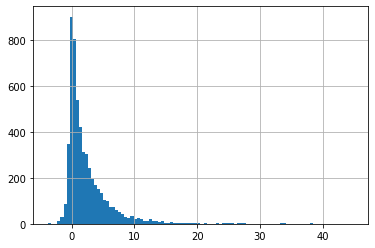

In [13]:
df['target'].hist(bins=100)

In [14]:
df['binary_target'] = 0
df.loc[df['target']>5, 'binary_target'] = 1
df['binary_target'].value_counts()

0    4643
1     836
Name: binary_target, dtype: int64

In [15]:
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target,binary_target
Date,,,,,,,,,,
2000-02-01,1394.459961,1412.489990,1384.790039,1409.280029,981000000,0,0,1465.150024,3.964435,0
2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1038600000,0,0,1465.150024,3.976243,0
2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1146500000,0,0,1465.150024,2.819712,0


#### create additional input features

In [16]:
df['lag21']=df['target'].shift(21)
df['lag31']=df['target'].shift(31)
df['lag41']=df['target'].shift(41)

df['open_close_diff'] = df['Close'] - df['Open']
df['day_change']=(100*df['open_close_diff']/df['Open']).round(2)
df['day_max_change'] = (100*(df['High'] - df['Low'])/df['Open']).round(2)

#create a binary feature: 1 day change
#0: decrease; 1: increase
df['oneday_change']=(df['Close'].diff()>0)+1-1

df['10day_change']=df['Close'].diff(10)
df['20day_change']=df['Close'].diff(20)


df['oneday_volchange']=(df['Volume'].diff()>0)+1-1

df['10day_volchange']=df['Volume'].diff(10)
df['20day_volchange']=df['Volume'].diff(20)


df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target,binary_target,...,lag41,open_close_diff,day_change,day_max_change,oneday_change,10day_change,20day_change,oneday_volchange,10day_volchange,20day_volchange
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,1394.459961,1412.489990,1384.790039,1409.280029,981000000,0,0,1465.150024,3.964435,0,...,NaN,14.820068,1.06,1.99,0,NaN,NaN,0,NaN,NaN
2000-02-02,1409.280029,1420.609985,1403.489990,1409.119995,1038600000,0,0,1465.150024,3.976243,0,...,NaN,-0.160034,-0.01,1.21,0,NaN,NaN,1,NaN,NaN
2000-02-03,1409.119995,1425.780029,1398.520020,1424.969971,1146500000,0,0,1465.150024,2.819712,0,...,NaN,15.849976,1.12,1.93,1,NaN,NaN,1,NaN,NaN


<AxesSubplot:>

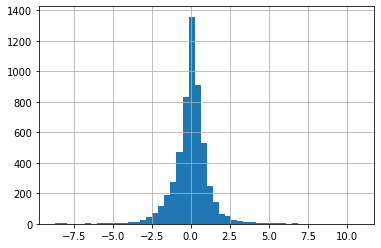

In [17]:
df['day_change'].hist(bins=50)

In [18]:
#convert day_change into categorical feature
#above 2- class 1; below -2 - class -1, in the middle - class0
df['day_change_cat']=0
df.loc[df['day_change']<=-2, 'day_change_cat']=-1
df.loc[df['day_change']>=2, 'day_change_cat']=1
df['day_change_cat'].value_counts()

 0    5095
-1     210
 1     174
Name: day_change_cat, dtype: int64

In [19]:
df.dropna(how='any', inplace=True)
print(df.shape, df.index.min())
df.head(3)

(5438, 23) 2000-03-30 00:00:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits,next_20day_max,target,binary_target,...,open_close_diff,day_change,day_max_change,oneday_change,10day_change,20day_change,oneday_volchange,10day_volchange,20day_volchange,day_change_cat
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-30,1508.520020,1517.380005,1474.630005,1487.920044,1193400000,0,0,1527.459961,2.657395,0,...,-20.599976,-1.37,2.83,0,29.450073,106.160034,1,-288900000.0,-5200000.0,0
2000-03-31,1487.920044,1519.810059,1484.380005,1498.579956,1227400000,0,0,1527.459961,1.927158,0,...,10.659912,0.72,2.38,1,34.109985,89.409912,1,-67700000.0,77100000.0,0
2000-04-03,1498.579956,1507.189941,1486.959961,1505.969971,1021700000,0,0,1527.459961,1.426987,0,...,7.390015,0.49,1.35,1,49.339966,114.689941,0,100900000.0,-7300000.0,0


# split data into simple training and testing subsets

In [20]:
target='binary_target'
bool_columns = ['oneday_change', 'oneday_volchange']

In [22]:
df.dropna(how='any', inplace=True)
train = df.copy(deep=True)

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [23]:
categorical_columns = ['day_change_cat']
categorical_dims =  {}
for col in categorical_columns:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = l_enc.fit_transform(train[col].values)
    
    categorical_dims[col] = len(l_enc.classes_)

categorical_dims

day_change_cat 3


{'day_change_cat': 3}

In [24]:
categorical_columns, categorical_dims

(['day_change_cat'], {'day_change_cat': 3})

# Define categorical features for categorical embeddings

In [25]:
unused_feat = ['Dividends', 'Stock Splits', 'next_20day_max',
               'open_close_diff', 'day_change' ]

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [26]:
print(features)

['Open', 'High', 'Low', 'Close', 'Volume', 'target', 'lag21', 'lag31', 'lag41', 'day_max_change', 'oneday_change', '10day_change', '20day_change', 'oneday_volchange', '10day_volchange', '20day_volchange', 'day_change_cat']


In [27]:
cat_idxs

[16]

In [28]:
cat_dims

[3]

# Network parameters

In [29]:
clf = TabNetClassifier(
    n_d=32, n_a=32, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cpu


In [82]:
clf2 = TabNetClassifier()
clf2

Device used : cpu


TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto')

# Training

In [30]:
train.shape

(5438, 23)

In [32]:
X_train = train[features].values[:-1500,:]
y_train = train[target].values[:-1500]

X_valid = train[features].values[-1450:-650,:]
y_valid = train[target].values[-1450:-650]

X_test = train[features].values[-600:, ]
y_test = train[target].values[-600:]

In [33]:
X_train.shape, X_valid.shape, X_test.shape

((3938, 17), (800, 17), (600, 17))

In [34]:
max_epochs = 50

In [35]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=1024, virtual_batch_size=256
) 

epoch 0  | loss: 0.6085  | train_auc: 0.5946  | valid_auc: 0.55134 |  0:00:00s
epoch 1  | loss: 0.25079 | train_auc: 0.72439 | valid_auc: 0.62383 |  0:00:01s
epoch 2  | loss: 0.20278 | train_auc: 0.74185 | valid_auc: 0.67725 |  0:00:02s
epoch 3  | loss: 0.16259 | train_auc: 0.77868 | valid_auc: 0.73814 |  0:00:03s
epoch 4  | loss: 0.1455  | train_auc: 0.823   | valid_auc: 0.88184 |  0:00:03s
epoch 5  | loss: 0.12248 | train_auc: 0.86481 | valid_auc: 0.80974 |  0:00:04s
epoch 6  | loss: 0.12148 | train_auc: 0.87193 | valid_auc: 0.73214 |  0:00:05s
epoch 7  | loss: 0.09959 | train_auc: 0.92461 | valid_auc: 0.855   |  0:00:05s
epoch 8  | loss: 0.1053  | train_auc: 0.90809 | valid_auc: 0.90169 |  0:00:06s
epoch 9  | loss: 0.10171 | train_auc: 0.92914 | valid_auc: 0.84598 |  0:00:07s
epoch 10 | loss: 0.09968 | train_auc: 0.88691 | valid_auc: 0.92718 |  0:00:07s
epoch 11 | loss: 0.07191 | train_auc: 0.88264 | valid_auc: 0.90451 |  0:00:08s
epoch 12 | loss: 0.07202 | train_auc: 0.89332 | vali

In [84]:
clf2.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=50,
    batch_size=1024, virtual_batch_size=128
) 

epoch 0  | loss: 0.04553 | train_auc: 0.98935 | valid_auc: 0.99878 |  0:00:00s
epoch 1  | loss: 0.04278 | train_auc: 0.98504 | valid_auc: 0.97955 |  0:00:00s
epoch 2  | loss: 0.02881 | train_auc: 0.98514 | valid_auc: 0.99199 |  0:00:00s
epoch 3  | loss: 0.04076 | train_auc: 0.98423 | valid_auc: 0.99251 |  0:00:01s
epoch 4  | loss: 0.03414 | train_auc: 0.98811 | valid_auc: 0.99318 |  0:00:01s
epoch 5  | loss: 0.03644 | train_auc: 0.99269 | valid_auc: 0.99511 |  0:00:01s
epoch 6  | loss: 0.02725 | train_auc: 0.9956  | valid_auc: 0.99439 |  0:00:01s
epoch 7  | loss: 0.0272  | train_auc: 0.99641 | valid_auc: 0.99542 |  0:00:02s
epoch 8  | loss: 0.03312 | train_auc: 0.99755 | valid_auc: 0.99533 |  0:00:02s
epoch 9  | loss: 0.03144 | train_auc: 0.9983  | valid_auc: 0.99587 |  0:00:02s
epoch 10 | loss: 0.03173 | train_auc: 0.99891 | valid_auc: 0.9969  |  0:00:02s
epoch 11 | loss: 0.02985 | train_auc: 0.99912 | valid_auc: 0.99827 |  0:00:03s
epoch 12 | loss: 0.02482 | train_auc: 0.99905 | vali

In [91]:
fig_list =[]

In [92]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
           
x_vals=list(range(1, max_epochs+1))

fig.add_trace(go.Scatter(
                        name="loss",
                        mode="lines", x=x_vals, y=clf.history['loss']),
              secondary_y=False
             )

fig.add_trace(go.Scatter(
                        name="train_auc",
                        mode="lines", x=x_vals,y=clf.history['train_auc']),
              secondary_y=True
             )

fig.add_trace(go.Scatter(
                        name="valid_auc",
                        mode="lines", x=x_vals,y=clf.history['valid_auc']),
              secondary_y=True
             )


fig.update_layout(hovermode="x unified", 
                  title_text="training data - loss and auc"
                 )



#fig.show()

fig_list.append(fig)

In [93]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
           
x_vals=list(range(1, max_epochs+1))

fig.add_trace(go.Scatter(
                        name="loss",
                        mode="lines", x=x_vals, y=clf2.history['loss']),
              secondary_y=False
             )

fig.add_trace(go.Scatter(
                        name="train_auc",
                        mode="lines", x=x_vals,y=clf2.history['train_auc']),
              secondary_y=True
             )

fig.add_trace(go.Scatter(
                        name="valid_auc",
                        mode="lines", x=x_vals,y=clf2.history['valid_auc']),
              secondary_y=True
             )


fig.update_layout(hovermode="x unified", 
                  title_text="training data - loss and auc - default hyperparameters"
                 )



#fig.show()

fig_list.append(fig)

### Predictions


In [88]:

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
preds = clf.predict_proba(X_test)
y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

preds_mapper2 = { idx : class_name for idx, class_name in enumerate(clf2.classes_)}
preds2 = clf2.predict_proba(X_test)
y_pred2 = np.vectorize(preds_mapper2.get)(np.argmax(preds2, axis=1))
test_acc2 = accuracy_score(y_pred=y_pred2, y_true=y_test)


print(f"BEST VALID SCORE FOR  : {clf.best_cost}, {clf2.best_cost}")
print(f"FINAL TEST SCORE FOR  : {test_acc}, {test_acc2}")

BEST VALID SCORE FOR  : 0.9993484148154181, 1.0
FINAL TEST SCORE FOR  : 0.9733333333333334, 0.9483333333333334


In [89]:
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)


y_pred2 = clf2.predict(X_test)
test_acc2 = accuracy_score(y_pred=y_pred2, y_true=y_test)
print(f"FINAL TEST SCORE FOR  : {test_acc}, {test_acc2}")

FINAL TEST SCORE FOR  : 0.9733333333333334, 0.9483333333333334


# Save and load Model

In [44]:
# save state dict
saved_filename = clf.save_model('binary_model')

Successfully saved model at binary_model.zip


In [45]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

Device used : cpu
Device used : cpu


In [46]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR  : {loaded_test_acc}")

FINAL TEST SCORE FOR  : 0.9733333333333334


In [47]:
test_acc == loaded_test_acc

True

# Global explainability : feat importance summing to 1

In [48]:
clf.feature_importances_

array([0.01141833, 0.10568571, 0.01697402, 0.0599244 , 0.0296432 ,
       0.2647944 , 0.01209274, 0.03980985, 0.02885467, 0.00494661,
       0.04379065, 0.04271051, 0.20845756, 0.00243536, 0.0882974 ,
       0.02919195, 0.01097264])

# Local explainability and masks

In [77]:
from matplotlib import pyplot as plt

In [78]:
explain_matrix, masks = clf.explain(X_test)

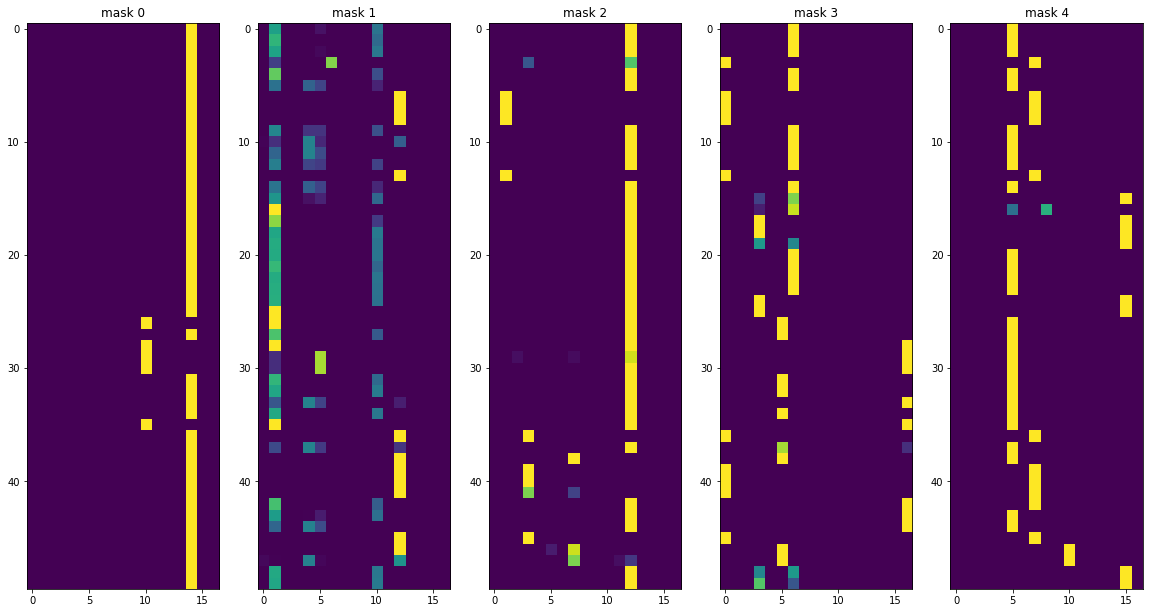

In [79]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

#### Export graphs to a html file

In [94]:
fig_path = r'html/tabnet_binary.html'
fig_list[0].write_html(fig_path)


with open(fig_path, 'a') as f:
    for fig_i in fig_list[1:]:
        f.write(fig_i.to_html(full_html=False, include_plotlyjs='cdn'))